# Diffusers library

## Structure

The API of diffusers consists of three main blocks: 

- **Pipelines**: high-level classes designed to rapidly generate samples from popular trained diffusion models in a user-friendly fashion.
- **Models**: popular architectures for training new diffusion models, e.g. UNet.
- **Schedulers**: various techniques for generating images from noise during inference as well as to generate noisy images for training.



Models and schedulers are kept as independent from each other as possible:
- a scheduler should never accept a model as an input and vice-versa. 
- The model predict the noise residual or slightly less noisy image with its trained weights, while the scheduler computes the previous sample given the model's output.

## Pipeline

In [1]:
from diffusers import DDPMPipeline

# from_pretrained() downloads the model and its configuration from Hugging Face
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")

C:\Users\fmbia\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The pipeline will generate a random initial noise sample and then iterate the diffusion process.

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:33<00:00,  6.52it/s]


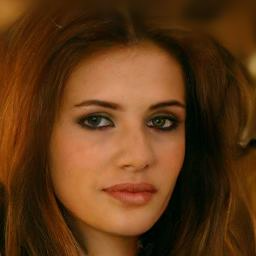

In [2]:
image_pipe.to("cuda")
images = image_pipe()["sample"]
images[0]

Let's take a look inside the pipeline

In [4]:
image_pipe

DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.2.4",
  "scheduler": [
    "diffusers",
    "DDPMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

The pipeline contains the ``DDPMScheduler`` and the ``UNet2DModel`` model. Let's look at them closely.

## Models

- Instances of the model class are neural networks that take a noisy ``sample`` as well as a ``timestep`` as inputs to predict a less noisy output ``sample``.
- We'll load a simple unconditional image generation model of type ``UNet2DModel`` trained on church images

In [5]:
from diffusers import UNet2DModel

repo_id = "google/ddpm-church-256"
model = UNet2DModel.from_pretrained(repo_id)

The model is a pure PyTorch ``torch.nn.Module`` class which you can see when printing out ``model``.

In [6]:
model

UNet2DModel(
  (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=128, out_features=512, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=512, out_features=512, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=512, out_features=128, bias=True)
          (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
        (1): ResnetBlock(
          (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
          (conv1

A concise description of the model configuration can be obtain from the ``config`` attribute

In [7]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('act_fn', 'silu'),
            ('attention_head_dim', None),
            ('norm_num_groups', 32),
            ('norm_eps', 

The model takes a random gaussian sample in the shape of an image (``batch_size``  ×  ``in_channels``  ×  ``image_size``  ×  ``image_size``).

In [8]:
import torch

noisy_sample = torch.randn(
    1, model.config.in_channels, model.config.sample_size, model.config.sample_size
)
noisy_sample.shape

torch.Size([1, 3, 256, 256])

To perform inference, we pass the noisy sample alongside a ``timestep`` through the model.

The model predicts either the slightly less noisy image, the difference between the slightly less noisy image and the input image or even something else. The information can be found in the model card.

In this case, the model predicts the noise residual $\boldsymbol{\tilde z_t}$, which has the same size of the input.

In [9]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2)["sample"]
     
noisy_residual.shape

torch.Size([1, 3, 256, 256])

The next step is to combine this model with the correct scheduler to generate actual images.

## Schedulers

- Schedulers are *algorithms* wrapped into a Python class. 
- Differently from models, schedulers have *no trainable weights*.
- They define the noise schedule which is used to add noise to the model during training, and also define the algorithm to compute the slightly less noisy sample given the model output

Run the ``from_config()`` method to load a configuration and instantiate a scheduler (note that for pipes and models we did something similar with ``from_pretrained()``).

In [10]:
from diffusers import DDPMScheduler

scheduler = DDPMScheduler.from_config(repo_id)

Like for models, we can access the configuration of the scheduler with ``config``. 

In [11]:
scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.0001),
            ('beta_end', 0.02),
            ('beta_schedule', 'linear'),
            ('trained_betas', None),
            ('variance_type', 'fixed_small'),
            ('clip_sample', True),
            ('_class_name', 'DDPMScheduler'),
            ('_diffusers_version', '0.2.4')])

Note:
- ``num_train_timesteps``: the length of the denoising process, e.g. how many timesteps are need to transform random gaussian noise to a data sample.
- ``beta_start`` and ``beta_end``: define the smallest and highest balues assumed by $\beta_t$
- ``beta_schedule``: define the noise changes over time, both in inference and training

All schedulers provide one or multiple ``step()`` methods that can be used to compute the slightly less noisy image. 

The ``step()`` method may vary from one scheduler to another, but normally expects:
- the model output (what we called  ``noisy_sample``)
- the ``timestep`` 
- the current ``noisy_sample``



In [12]:
less_noisy_sample = scheduler.step(
    model_output=noisy_residual, timestep=13, sample=noisy_sample
)["prev_sample"]
less_noisy_sample.shape

torch.Size([1, 3, 256, 256])

**Note** some schedulers might implement ``step()`` slightly differently: always check the code/documentation of the API

Time to define the **denoising loop**.

- We loop over ``scheduler.timesteps``, a tensor defining the sequence of timesteps over which to iterate during the denoising process. 
- Usually, the denoising process goes in decreasing order of timesteps (here from 1000 to 0).
- To visualize what is going on, we print out the (less and less) noisy samples every 50 steps.

In [13]:
import PIL.Image
import numpy as np

# define the function to visualize the images as they get denoised
def display_sample(sample, i):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])
    display(f"Image at step {i}")
    display(image_pil)

In [14]:
# move model and input to gpu to speed things up
model.to("cuda")
noisy_sample = noisy_sample.to("cuda")

  5%|███▉                                                                            | 49/1000 [00:07<02:19,  6.81it/s]

'Image at step 50'

 10%|███████▉                                                                        | 99/1000 [00:14<02:12,  6.79it/s]

'Image at step 100'

 15%|███████████▊                                                                   | 149/1000 [00:22<02:05,  6.77it/s]

'Image at step 150'

 20%|███████████████▋                                                               | 199/1000 [00:29<01:58,  6.76it/s]

'Image at step 200'

 25%|███████████████████▋                                                           | 249/1000 [00:37<01:51,  6.72it/s]

'Image at step 250'

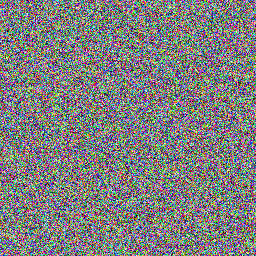

 30%|███████████████████████▌                                                       | 299/1000 [00:44<01:44,  6.70it/s]

'Image at step 300'

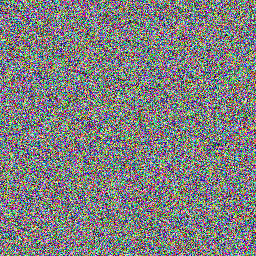

 35%|███████████████████████████▌                                                   | 349/1000 [00:52<01:37,  6.70it/s]

'Image at step 350'

 40%|███████████████████████████████▌                                               | 399/1000 [00:59<01:31,  6.60it/s]

'Image at step 400'

 45%|███████████████████████████████████▍                                           | 449/1000 [01:07<01:22,  6.66it/s]

'Image at step 450'

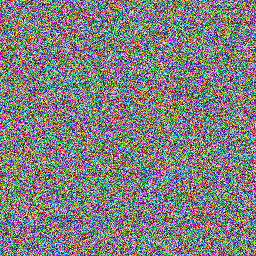

 50%|███████████████████████████████████████▍                                       | 499/1000 [01:14<01:14,  6.69it/s]

'Image at step 500'

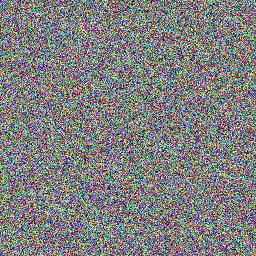

 55%|███████████████████████████████████████████▎                                   | 549/1000 [01:22<01:08,  6.63it/s]

'Image at step 550'

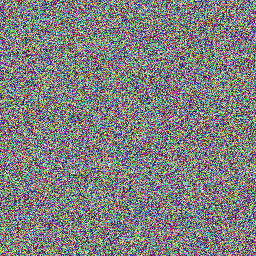

 60%|███████████████████████████████████████████████▎                               | 599/1000 [01:29<01:00,  6.59it/s]

'Image at step 600'

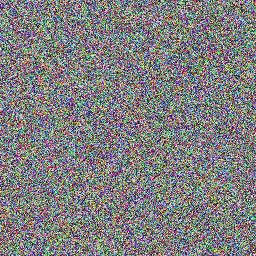

 65%|███████████████████████████████████████████████████▎                           | 649/1000 [01:37<00:53,  6.61it/s]

'Image at step 650'

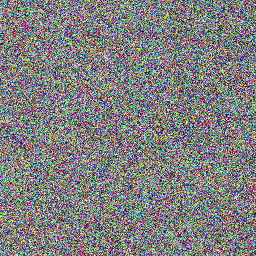

 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [01:45<00:47,  6.39it/s]

'Image at step 700'

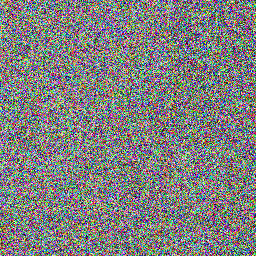

 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [01:52<00:37,  6.75it/s]

'Image at step 750'

 80%|███████████████████████████████████████████████████████████████                | 799/1000 [02:00<00:29,  6.72it/s]

'Image at step 800'

 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [02:07<00:22,  6.74it/s]

'Image at step 850'

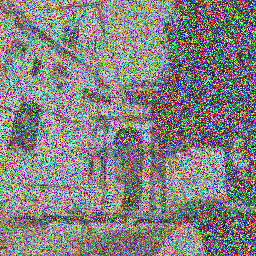

 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [02:15<00:16,  6.02it/s]

'Image at step 900'

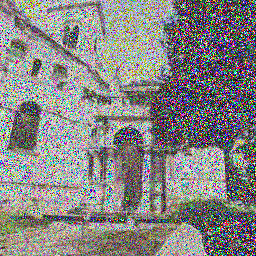

 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [02:23<00:08,  6.27it/s]

'Image at step 950'

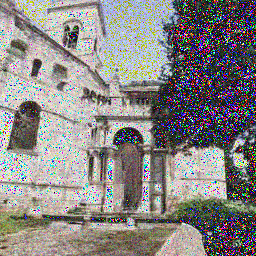

100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [02:30<00:00,  6.58it/s]

'Image at step 1000'

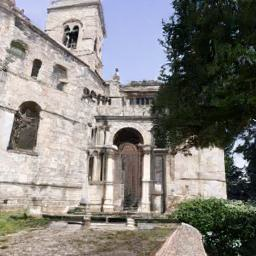

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:31<00:00,  6.62it/s]


In [15]:
import tqdm

sample = noisy_sample # pure noise

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t)["sample"]

  # 2. compute less noisy image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample)["prev_sample"]

  # 3. optionally look at image
  if (i + 1) % 50 == 0:
      display_sample(sample, i + 1)

- It takes quite some time to produce a meaningful image
- To speed-up the generation, we switch the DDPM scheduler with the DDIM scheduler
- Note that some schedulers follow different protocols and cannot be switched so easily like in this case

In [16]:
from diffusers import DDIMScheduler

scheduler = DDIMScheduler.from_config(repo_id)

{'set_alpha_to_one', 'timestep_values'} was not found in config. Values will be initialized to default values.


- The DDIM scheduler allows the user specify the number of inference steps
- In this case, we use only 50

In [17]:
scheduler.set_timesteps(num_inference_steps=50)

 18%|██████████████▉                                                                    | 9/50 [00:01<00:06,  6.82it/s]

'Image at step 10'

 38%|███████████████████████████████▏                                                  | 19/50 [00:02<00:04,  6.70it/s]

'Image at step 20'

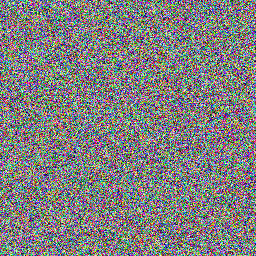

 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:04<00:03,  6.66it/s]

'Image at step 30'

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:05<00:01,  6.53it/s]

'Image at step 40'

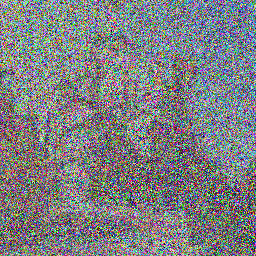

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:07<00:00,  6.62it/s]

'Image at step 50'

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.55it/s]


In [18]:
import tqdm

sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
  # 1. predict noise residual
  with torch.no_grad():
      residual = model(sample, t)["sample"]

  # 2. compute previous image and set x_t -> x_t-1
  sample = scheduler.step(residual, t, sample)["prev_sample"]

  # 3. optionally look at image
  if (i + 1) % 10 == 0:
      display_sample(sample, i + 1)

## Stable Diffusion

- Stable Diffusion is based on a particular type of diffusion model called *Latent Diffusion*
- Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a **lower dimensional latent space**, instead of using the actual pixel space

There are 3 main components in the latent diffusion model.

1. The U-Net (as in DDPM/DDIM)
2. An autoencoder (VAE)
3. A text-encoder (CLIP)

- The **text-encoder** is responsible for transforming an input prompt into an embedding space that can be understood by the U-Net 
- It is usually a simple transformer-based encoder that maps a sequence of tokens (generated with a **tokenizer**) into a sequence of latent text-embeddings
- Stable Diffusion does not train the text-encoder and simply uses an already trained text encoder such as CLIP or BERT

The VAE model has two parts:
- the **encoder** is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net
- the **decoder** transforms the latent representation back into an image.
- During **training**, the encoder is used to get the latent representations of the images for the forward diffusion process 
- During **inference**, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder
- Working with latens is the key of the speed and memory efficiency of Stable Diffusion
- The VAE reduces the input size by a factor of 8

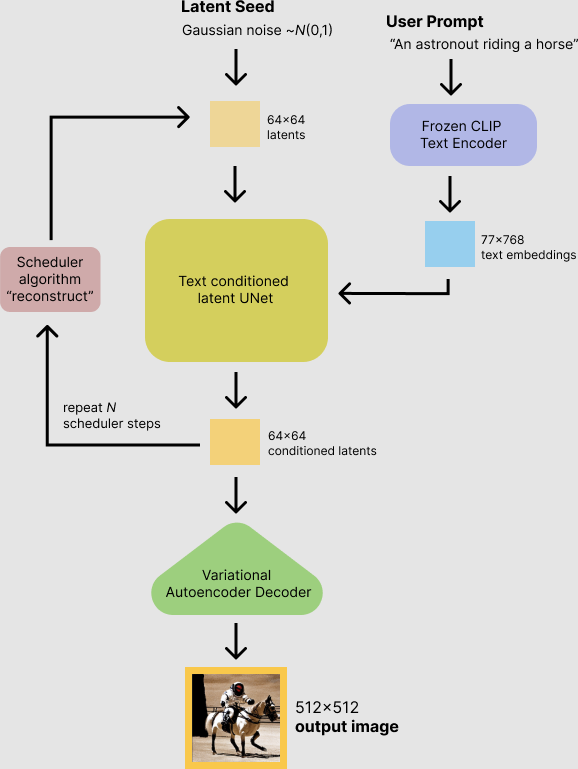

### Pre-built pipeline

First, we look at the pre-built pipeline

In [27]:
with open("C:\\Users\\fmbia\\OneDrive\\Documenti\\hugging_face_token.txt","r") as f:
    token = f.read()

In [28]:
from diffusers import StableDiffusionPipeline

# get your token at https://huggingface.co/settings/tokens
image_pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", use_auth_token=token)
image_pipe.to("cuda")

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 8.00 GiB total capacity; 7.24 GiB already allocated; 0 bytes free; 7.31 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

- ``guidance_scale`` forces the generation to better match the prompt potentially at the cost of image quality or diversity. Values between 7 and 8.5 are usually good choices
- Make sure ``height`` and ``width`` are both multiples of 8
- Going below 512 might result in lower quality images.
- Going over 512 in both directions will repeat image areas (global coherence is lost).
- The best way to create non-square images is to use 512 in one dimension, and a value larger than that in the other one.

In [26]:
prompt = "a photograph of a cat with a funny hat"

# for reproducibility
generator = torch.Generator("cuda").manual_seed(1024)

image = image_pipe(prompt,  
                   guidance_scale=7.5, 
                   num_inference_steps=15, 
                   generator=generator, 
                   height=512, 
                   width=768
                   )["sample"][0]

0it [00:00, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 2.25 GiB (GPU 0; 8.00 GiB total capacity; 6.21 GiB already allocated; 0 bytes free; 6.27 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
image